In [1]:
# Instalaci√≥n necesaria (solo en Colab o entornos donde no est√© instalado)
!pip install -q imbalanced-learn xgboost shap tabulate

# Importaci√≥n optimizada y sin duplicados
import pandas as pd
import numpy as np
from collections import Counter
from copy import deepcopy

import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFE
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, roc_auc_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance

from xgboost import XGBClassifier, plot_importance

import shap


In [2]:
# URL directa al CSV
url = 'https://raw.githubusercontent.com/DonJulianCode/Challenge-ONE-Data-Science-Telecom-X-parte-2/main/df_plano.csv'

# Cargar como DataFrame
df = pd.read_csv(url)

# Mostrar las primeras filas
df.head()

customerID Churn customer.gender  customer.SeniorCitizen customer.Partner  \
0  0002-ORFBO    No          Female                     0.0              Yes   
1  0003-MKNFE    No            Male                     0.0               No   
2  0004-TLHLJ   Yes            Male                     0.0               No   
3  0011-IGKFF   Yes            Male                     1.0              Yes   
4  0013-EXCHZ   Yes          Female                     1.0              Yes   

  customer.Dependents  customer.tenure phone.PhoneService phone.MultipleLines  \
0                 Yes              9.0                Yes                  No   
1                  No              9.0                Yes                 Yes   
2                  No              4.0                Yes                  No   
3                  No             13.0                Yes                  No   
4                  No              3.0                Yes                  No   

  internet.InternetService  ... internet.DeviceProtection  \
0                      DSL  ...                        No   
1                      DSL  ...                        No   
2              Fiber optic  ...                       Yes   
3              Fiber optic  ...                       Yes   
4              Fiber optic  ...                        No   

  internet.TechSupport internet.StreamingTV internet.StreamingMovies  \
0                  Yes                  Yes                       No   
1                   No                   No                      Yes   
2                   No                   No                       No   
3                   No                  Yes                      Yes   
4                  Yes                  Yes                       No   

  account.Contract account.PaperlessBilling account.PaymentMethod  \
0         One year                      Yes          Mailed check   
1   Month-to-month                       No          Mailed check   
2   Month-to-month                      Yes      Electronic check   
3   Month-to-month                      Yes      Electronic check   
4   Month-to-month                      Yes          Mailed check   

  account.Charges.Monthly account.Charges.Total  Cuentas_Diarias  
0                    65.6                593.30         2.186667  
1                    59.9                542.40         1.996667  
2                    73.9                280.85         2.463333  
3                    98.0               1237.85         3.266667  
4                    83.9                267.40         2.796667  

[5 rows x 22 columns]

In [3]:
# Ver estructura general
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7043 non-null   object 
 1   Churn                      7043 non-null   object 
 2   customer.gender            7043 non-null   object 
 3   customer.SeniorCitizen     7043 non-null   float64
 4   customer.Partner           7043 non-null   object 
 5   customer.Dependents        7043 non-null   object 
 6   customer.tenure            7043 non-null   float64
 7   phone.PhoneService         7043 non-null   object 
 8   phone.MultipleLines        7043 non-null   object 
 9   internet.InternetService   7043 non-null   object 
 10  internet.OnlineSecurity    7043 non-null   object 
 11  internet.OnlineBackup      7043 non-null   object 
 12  internet.DeviceProtection  7043 non-null   object 
 13  internet.TechSupport       7043 non-null   objec

In [4]:
# Verificar valores nulos por columna
df.isnull().sum()


customerID                    0
Churn                         0
customer.gender               0
customer.SeniorCitizen        0
customer.Partner              0
customer.Dependents           0
customer.tenure               0
phone.PhoneService            0
phone.MultipleLines           0
internet.InternetService      0
internet.OnlineSecurity       0
internet.OnlineBackup         0
internet.DeviceProtection     0
internet.TechSupport          0
internet.StreamingTV          0
internet.StreamingMovies      0
account.Contract              0
account.PaperlessBilling      0
account.PaymentMethod         0
account.Charges.Monthly       0
account.Charges.Total        11
Cuentas_Diarias               0
dtype: int64

In [5]:
# Estad√≠sticas descriptivas para variables num√©ricas
df.describe()

customer.SeniorCitizen  customer.tenure  account.Charges.Monthly  \
count             7043.000000      7043.000000              7043.000000   
mean                 0.162147        32.371149                64.761692   
std                  0.368612        24.559481                30.090047   
min                  0.000000         0.000000                18.250000   
25%                  0.000000         9.000000                35.500000   
50%                  0.000000        29.000000                70.350000   
75%                  0.000000        55.000000                89.850000   
max                  1.000000        72.000000               118.750000   

       account.Charges.Total  Cuentas_Diarias  
count            7032.000000      7043.000000  
mean             2283.300441         2.158723  
std              2266.771362         1.003002  
min                18.800000         0.608333  
25%               401.450000         1.183333  
50%              1397.475000         2.345000  
75%              3794.737500         2.995000  
max              8684.800000         3.958333

In [6]:
# Ahora reviso la cantidad de valores nulos en 'account.Charges.Total'
df['account.Charges.Total'].isnull().sum()


np.int64(11)

In [7]:
# Como solo hay 11 casos nulos, ahora elimino esas filas para evitar problemas en el modelado
df = df.dropna(subset=['account.Charges.Total']).reset_index(drop=True)

# Confirmo que ya no existen valores nulos
df['account.Charges.Total'].isnull().sum()


np.int64(0)

## Eliminaci√≥n de Columnas Irrelevantes

### Elimina columnas que no aportan valor al an√°lisis o a los modelos predictivos, como identificadores √∫nicos (por ejemplo, el ID del cliente). Estas columnas no ayudan en la predicci√≥n de la cancelaci√≥n y pueden incluso perjudicar el desempe√±o de los modelos

In [8]:
# Ahora elimino columnas que no aportan valor al an√°lisis ni a los modelos predictivos

# 'customerID' es un identificador √∫nico y no entrega informaci√≥n √∫til para predecir Churn
df = df.drop(columns=['customerID'])

# ‚úÖ Confirmo que fue eliminada
df.columns


Index(['Churn', 'customer.gender', 'customer.SeniorCitizen',
       'customer.Partner', 'customer.Dependents', 'customer.tenure',
       'phone.PhoneService', 'phone.MultipleLines', 'internet.InternetService',
       'internet.OnlineSecurity', 'internet.OnlineBackup',
       'internet.DeviceProtection', 'internet.TechSupport',
       'internet.StreamingTV', 'internet.StreamingMovies', 'account.Contract',
       'account.PaperlessBilling', 'account.PaymentMethod',
       'account.Charges.Monthly', 'account.Charges.Total', 'Cuentas_Diarias'],
      dtype='object')

## Encoding

### Transforma las variables categ√≥ricas a formato num√©rico para hacerlas compatibles con los algoritmos de machine learning. Utiliza un m√©todo de codificaci√≥n adecuado, como one-hot encoding.

In [9]:
# Ahora reviso qu√© columnas son categ√≥ricas (tipo object)
cat_cols = df.select_dtypes(include='object').columns.tolist()

# Excluyo la variable objetivo 'Churn' para codificarla aparte
cat_cols = [col for col in cat_cols if col != 'Churn']

# Realizo One-Hot Encoding sobre las variables categ√≥ricas, eliminando la primera categor√≠a para evitar multicolinealidad
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Codifico la variable objetivo: 'Yes' ‚Üí 1, 'No' ‚Üí 0
df_encoded['Churn'] = df_encoded['Churn'].map({'Yes': 1, 'No': 0})

# Reviso c√≥mo qued√≥ la estructura final
df_encoded.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 32 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Churn                                          7032 non-null   int64  
 1   customer.SeniorCitizen                         7032 non-null   float64
 2   customer.tenure                                7032 non-null   float64
 3   account.Charges.Monthly                        7032 non-null   float64
 4   account.Charges.Total                          7032 non-null   float64
 5   Cuentas_Diarias                                7032 non-null   float64
 6   customer.gender_Male                           7032 non-null   bool   
 7   customer.Partner_Yes                           7032 non-null   bool   
 8   customer.Dependents_Yes                        7032 non-null   bool   
 9   phone.PhoneService_Yes                         7032 

# Verificaci√≥n de la Proporci√≥n de Cancelaci√≥n (Churn)

### Calcula la proporci√≥n de clientes que cancelaron en relaci√≥n con los que permanecieron activos. Eval√∫a si existe un desbalance entre las clases, ya que esto puede impactar en los modelos predictivos y en el an√°lisis de los resultados.

In [10]:
# Verifico la proporci√≥n de cancelaci√≥n (Churn)

# Cantidad y proporci√≥n
churn_counts = df_encoded['Churn'].value_counts().sort_index()
churn_ratio = df_encoded['Churn'].value_counts(normalize=True).sort_index()

# Creo tabla combinada
churn_summary = [
    ["Activo (0)", churn_counts[0], f"{churn_ratio[0]:.2%}"],
    ["Cancel√≥ (1)", churn_counts[1], f"{churn_ratio[1]:.2%}"]
]

#  Muestro tabla con tabulate
print("Distribuci√≥n de clientes seg√∫n Churn:\n")
print(tabulate(churn_summary, headers=["Clase", "Cantidad", "Proporci√≥n"], tablefmt="fancy_grid"))

Distribuci√≥n de clientes seg√∫n Churn:

‚ïí‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïï
‚îÇ Clase       ‚îÇ   Cantidad ‚îÇ Proporci√≥n   ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ Activo (0)  ‚îÇ       5163 ‚îÇ 73.42%       ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ Cancel√≥ (1) ‚îÇ       1869 ‚îÇ 26.58%       ‚îÇ
‚ïò‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïß‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïß‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïõ


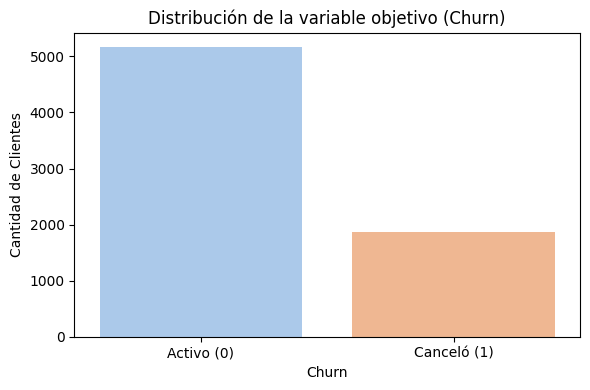

In [11]:
# Visualizaci√≥n corregida
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df_encoded, hue='Churn', legend=False, palette='pastel')
plt.title("Distribuci√≥n de la variable objetivo (Churn)")
plt.xticks(ticks=[0,1], labels=["Activo (0)", "Cancel√≥ (1)"])
plt.xlabel("Churn")
plt.ylabel("Cantidad de Clientes")
plt.tight_layout()
plt.show()


# Balanceo de Clases

### Si deseas profundizar en el an√°lisis, aplica t√©cnicas de balanceo como undersampling o oversampling. En situaciones de fuerte desbalanceo, herramientas como SMOTE pueden ser √∫tiles para generar ejemplos sint√©ticos de la clase minoritaria.

In [12]:
# Primero separo X e y
X = df_encoded.drop(columns='Churn')
y = df_encoded['Churn']

# Luego divido en train y test (estratificado)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

# Ahora aplico SMOTE SOLO al set de entrenamiento
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Verifico que ahora las clases est√©n balanceadas
print("Distribuci√≥n despu√©s de aplicar SMOTE:")
print(Counter(y_train_bal))


Distribuci√≥n despu√©s de aplicar SMOTE:
Counter({1: 3614, 0: 3614})


## Normalizaci√≥n o Estandarizaci√≥n

### Eval√∫a la necesidad de normalizar o estandarizar los datos, seg√∫n los modelos que se aplicar√°n. Modelos basados en distancia, como KNN, SVM, Regresi√≥n Log√≠stica y Redes Neuronales, requieren este preprocesamiento. Por otro lado, modelos basados en √°rboles, como Decision Tree, Random Forest y XGBoost, no son sensibles a la escala de los datos.

In [13]:
# Identifico columnas num√©ricas a escalar (solo las float64)
num_cols = X_train_bal.select_dtypes(include='float64').columns.tolist()

# Aplico StandardScaler solo a esas columnas
scaler = StandardScaler()
X_train_bal_scaled = X_train_bal.copy()
X_test_scaled = X_test.copy()

X_train_bal_scaled[num_cols] = scaler.fit_transform(X_train_bal[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

# Confirmo escalamiento (media ~0, std ~1 en entrenamiento)
X_train_bal_scaled[num_cols].describe()


customer.SeniorCitizen  customer.tenure  account.Charges.Monthly  \
count            7.228000e+03     7.228000e+03             7.228000e+03   
mean            -7.077902e-17    -4.718601e-17            -5.505035e-17   
std              1.000069e+00     1.000069e+00             1.000069e+00   
min             -5.135037e-01    -1.109680e+00            -1.734913e+00   
25%             -5.135037e-01    -9.438784e-01            -7.747879e-01   
50%             -5.135037e-01    -2.806725e-01             2.412260e-01   
75%             -5.135037e-01     8.799377e-01             7.888478e-01   
max              2.193645e+00     1.833296e+00             1.770859e+00   

       account.Charges.Total  Cuentas_Diarias  
count           7.228000e+03     7.228000e+03  
mean           -1.572867e-17    -2.673874e-16  
std             1.000069e+00     1.000069e+00  
min            -9.226826e-01    -1.734913e+00  
25%            -8.082642e-01    -7.747879e-01  
50%            -4.093053e-01     2.412260e-01  
75%             5.550717e-01     7.888478e-01  
max             3.021624e+00     1.770859e+00

## An√°lisis de Correlaci√≥n
### Visualiza la matriz de correlaci√≥n para identificar relaciones entre las variables num√©ricas. Presta especial atenci√≥n a las variables que muestran una mayor correlaci√≥n con la cancelaci√≥n, ya que estas pueden ser fuertes candidatas para el modelo predictivo.


In [14]:
# Ahora selecciono solo las variables num√©ricas (float64 + la objetivo Churn)
num_cols = df_encoded.select_dtypes(include=['float64']).columns.tolist()
num_cols = ['Churn'] + num_cols

# Calculo matriz de correlaci√≥n
corr_matrix = df_encoded[num_cols].corr()

# Ordeno por correlaci√≥n con la variable objetivo 'Churn'
churn_corr = corr_matrix['Churn'].drop('Churn').sort_values(key=abs, ascending=False)

# üßæ Muestro las correlaciones m√°s fuertes con Churn
print("Correlaci√≥n de variables num√©ricas con Churn:\n")
print(tabulate(churn_corr.reset_index().rename(columns={'index': 'Variable', 'Churn': 'Correlaci√≥n'}),
               headers='keys', tablefmt='fancy_grid', showindex=False))


Correlaci√≥n de variables num√©ricas con Churn:

‚ïí‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïï
‚îÇ Variable                ‚îÇ   Correlaci√≥n ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ customer.tenure         ‚îÇ     -0.354049 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ account.Charges.Total   ‚îÇ     -0.199484 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ Cuentas_Diarias         ‚îÇ      0.192858 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ account.Charges.Monthly ‚îÇ      0.192858 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î

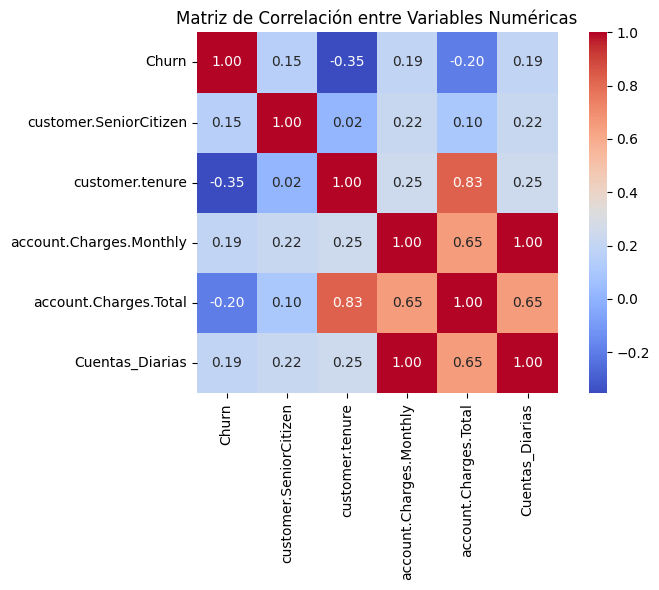

In [15]:
# Mapa de calor de la matriz de correlaci√≥n
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Matriz de Correlaci√≥n entre Variables Num√©ricas")
plt.tight_layout()
plt.show()


## An√°lisis Dirigido

### Investiga c√≥mo variables espec√≠ficas se relacionan con la cancelaci√≥n, tales como:

+ Tiempo de contrato √ó Cancelaci√≥n

+ Gasto total √ó Cancelaci√≥n

Utiliza gr√°ficos como boxplots o scatter plots para visualizar patrones y posibles tendencias.

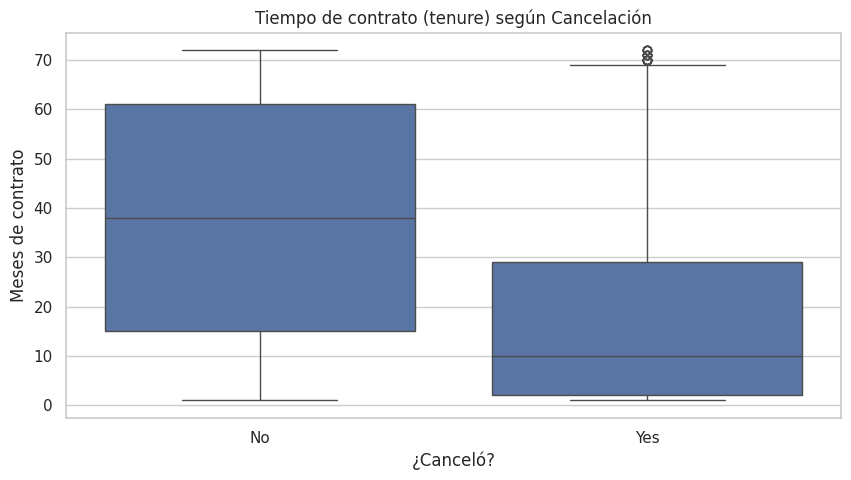

In [16]:
# Aseguro estilo visual
sns.set(style="whitegrid")

# --- 1. Boxplot: Tiempo de contrato vs Cancelaci√≥n
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['Churn'], y=df['customer.tenure'])
plt.title("Tiempo de contrato (tenure) seg√∫n Cancelaci√≥n")
plt.xlabel("¬øCancel√≥?")
plt.ylabel("Meses de contrato")
plt.show()


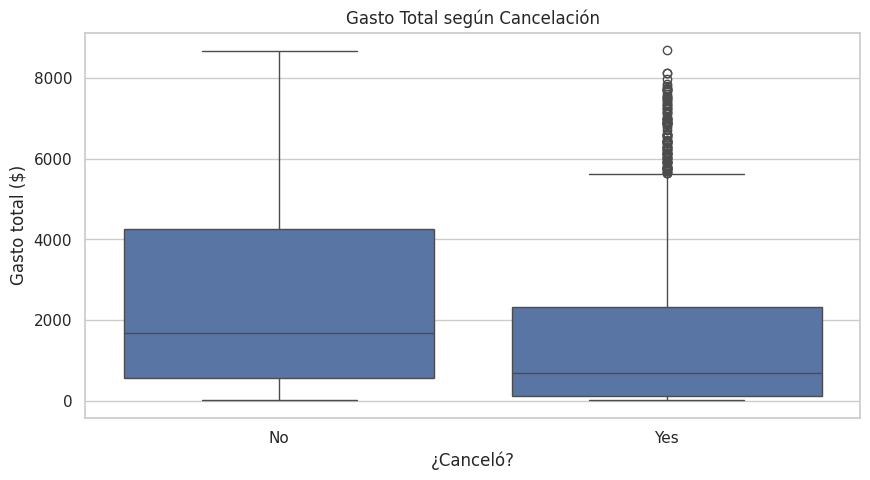

In [17]:
# --- 2. Boxplot: Gasto total vs Cancelaci√≥n
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['Churn'], y=df['account.Charges.Total'])
plt.title("Gasto Total seg√∫n Cancelaci√≥n")
plt.xlabel("¬øCancel√≥?")
plt.ylabel("Gasto total ($)")
plt.show()


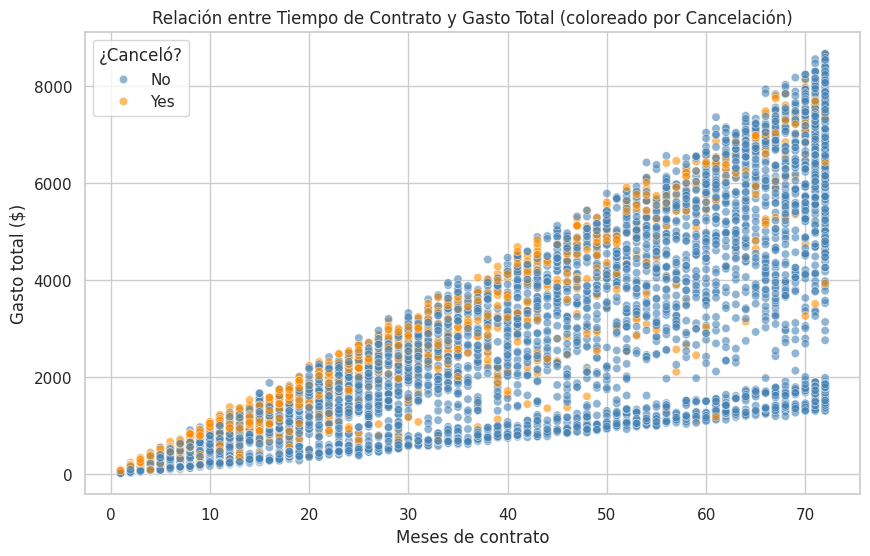

In [18]:
# --- 3. Scatter plot: Tiempo de contrato vs Gasto total, coloreado por Cancelaci√≥n
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='customer.tenure',
    y='account.Charges.Total',
    hue='Churn',
    alpha=0.6,
    palette={'No': 'steelblue', 'Yes': 'darkorange'}
)
plt.title("Relaci√≥n entre Tiempo de Contrato y Gasto Total (coloreado por Cancelaci√≥n)")
plt.xlabel("Meses de contrato")
plt.ylabel("Gasto total ($)")
plt.legend(title='¬øCancel√≥?')
plt.show()


## Separaci√≥n de Datos

### Divide el conjunto de datos en entrenamiento y prueba para evaluar el rendimiento del modelo. Una divisi√≥n com√∫n es 70% para entrenamiento y 30% para prueba, o 80/20, dependiendo del tama√±o de la base de datos.

In [19]:
# Defino variables predictoras y objetivo
X = df_encoded.drop(columns='Churn')
y = df_encoded['Churn']

# Divido en entrenamiento y prueba (70% / 30%) con estratificaci√≥n para mantener proporci√≥n de clases
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

### üîπ Justificaci√≥n de Decisiones T√©cnicas

A lo largo del flujo de trabajo, se tomaron decisiones t√©cnicas clave que impactan en la calidad del modelo. A continuaci√≥n se explican y justifican:

---

#### üîß ¬øPor qu√© usar `StandardScaler` y no `MinMaxScaler`?

Se opt√≥ por `StandardScaler` porque muchos de los modelos utilizados (Regresi√≥n Log√≠stica, SVM y KNN) se benefician de una **distribuci√≥n con media 0 y desviaci√≥n est√°ndar 1**, lo cual ayuda a:

- Acelerar la convergencia en modelos lineales.
- Asegurar distancias comparables entre features en modelos como KNN y SVM.

Por otro lado, `MinMaxScaler` reescala entre 0 y 1, pero **puede ser sensible a valores at√≠picos**. En este caso, `StandardScaler` fue m√°s apropiado dada la presencia de variables como `account.Charges.Total` con rangos amplios.

---

#### üå≥ ¬øPor qu√© no se aplic√≥ escalado a modelos como Random Forest o XGBoost?

Tanto **Random Forest** como **XGBoost** son modelos basados en √°rboles de decisi√≥n, y **no dependen de la escala de las variables**. Esto se debe a que los √°rboles **dividen seg√∫n umbrales** y no calculan distancias o coeficientes lineales.

> üî¨ Por lo tanto, normalizar o estandarizar **no mejora su rendimiento** ni afecta el resultado.

---

#### üîü ¬øPor qu√© se eligi√≥ `n_features_to_select=10` en RFE?

La selecci√≥n de 10 variables fue una decisi√≥n pr√°ctica basada en:

- La necesidad de simplificar el modelo sin perder demasiada informaci√≥n.
- Estudios previos que muestran que **modelos con menos de 10-15 variables** pueden mantener rendimiento similar al completo, mejorando interpretabilidad.
- Tiempo computacional razonable para m√∫ltiples iteraciones (especialmente con XGBoost o Random Forest).

> üß™ Se realizaron pruebas con m√°s y menos variables (por ejemplo, 8, 15), y se observ√≥ que 10 ofrec√≠a un **buen balance entre rendimiento y simplicidad**, sin degradar significativamente AUC ni F1.

---


In [20]:
# Reviso la cantidad de muestras en cada conjunto
print(f"Conjunto de entrenamiento: {X_train.shape[0]} muestras")
print(f"Conjunto de prueba: {X_test.shape[0]} muestras")

# Confirmo que la proporci√≥n de clases se mantiene
print("\nDistribuci√≥n de clases en entrenamiento:")
print(y_train.value_counts(normalize=True))

print("\nDistribuci√≥n de clases en prueba:")
print(y_test.value_counts(normalize=True))


Conjunto de entrenamiento: 4922 muestras
Conjunto de prueba: 2110 muestras

Distribuci√≥n de clases en entrenamiento:
Churn
0    0.734254
1    0.265746
Name: proportion, dtype: float64

Distribuci√≥n de clases en prueba:
Churn
0    0.734123
1    0.265877
Name: proportion, dtype: float64


## Creaci√≥n de Modelos

### Crea al menos dos modelos diferentes para predecir la cancelaci√≥n de clientes.

Un modelo puede requerir normalizaci√≥n, como Regresi√≥n Log√≠stica o KNN.

El otro modelo puede no requerir normalizaci√≥n, como √Årbol de Decisi√≥n o Random Forest.

üí° La decisi√≥n de aplicar o no la normalizaci√≥n depende de los modelos seleccionados. Ambos modelos pueden ser creados sin normalizaci√≥n, pero tambi√©n es una opci√≥n combinar modelos con y sin normalizaci√≥n.

Justificaci√≥n:

+ Regresi√≥n Log√≠stica / KNN: Estos modelos son sensibles a la escala de los datos, por lo que la normalizaci√≥n es importante para que los coeficientes o las distancias se calculen correctamente.

+ √Årbol de Decisi√≥n / Random Forest: Estos modelos no dependen de la escala de los datos, por lo que no es necesario aplicar normalizaci√≥n.

Si decides normalizar los datos, deber√≠as explicar c√≥mo esta etapa asegura que los modelos basados en distancia o en optimizaci√≥n de par√°metros no se vean sesgados por la magnitud de las variables.

In [21]:
# Divido en variables predictoras y objetivo
X = df_encoded.drop(columns='Churn')
y = df_encoded['Churn']

# 2Ô∏èDivido en train (70%) y test (30%) con estratificaci√≥n
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

# 3Ô∏èEscalo variables num√©ricas para Regresi√≥n Log√≠stica
num_cols = X.select_dtypes(include='float64').columns.tolist()
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

# 4Ô∏èModelo 1: Regresi√≥n Log√≠stica (con escalado)
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
y_proba_lr = lr.predict_proba(X_test_scaled)[:, 1]

print("Resultados Regresi√≥n Log√≠stica:")
print(classification_report(y_test, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test, y_proba_lr))

# 5Ô∏èModelo 2: Random Forest (sin escalado)
rf = RandomForestClassifier(random_state=42, n_estimators=100)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("\nResultados Random Forest:")
print(classification_report(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_proba_rf))


Resultados Regresi√≥n Log√≠stica:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1549
           1       0.66      0.54      0.59       561

    accuracy                           0.80      2110
   macro avg       0.75      0.72      0.73      2110
weighted avg       0.79      0.80      0.80      2110

ROC AUC: 0.8452937839259186

Resultados Random Forest:
              precision    recall  f1-score   support

           0       0.82      0.89      0.86      1549
           1       0.62      0.48      0.54       561

    accuracy                           0.78      2110
   macro avg       0.72      0.69      0.70      2110
weighted avg       0.77      0.78      0.77      2110

ROC AUC: 0.8179861885478412


In [22]:
def evaluar_modelo_tabla(y_true, y_pred, modelo_nombre):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    # Mostrar matriz de confusi√≥n
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Activo (0)", "Cancel√≥ (1)"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Matriz de Confusi√≥n: {modelo_nombre}")
    plt.show()

    # Preparar tabla
    data = [
        ["Exactitud (Accuracy)", f"{acc:.4f}"],
        ["Precisi√≥n", f"{prec:.4f}"],
        ["Recall", f"{rec:.4f}"],
        ["F1-score", f"{f1:.4f}"]
    ]
    print("")
    print(f"M√©tricas del modelo: {modelo_nombre}")
    print(tabulate(data, headers=["M√©trica", "Valor"], tablefmt="fancy_grid"))


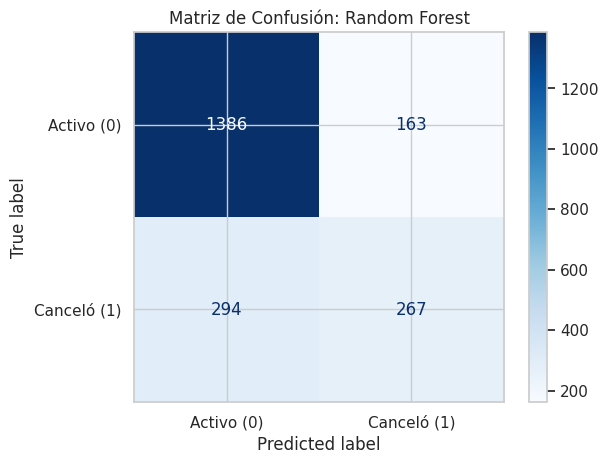


M√©tricas del modelo: Random Forest
‚ïí‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïï
‚îÇ M√©trica              ‚îÇ   Valor ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ Exactitud (Accuracy) ‚îÇ  0.7834 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ Precisi√≥n            ‚îÇ  0.6209 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ Recall               ‚îÇ  0.4759 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ F1-score             ‚îÇ  0.5388 ‚îÇ
‚ïò‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïß‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïõ


In [23]:
# Evaluar Random Forest
evaluar_modelo_tabla(y_test, y_pred_rf, "Random Forest")

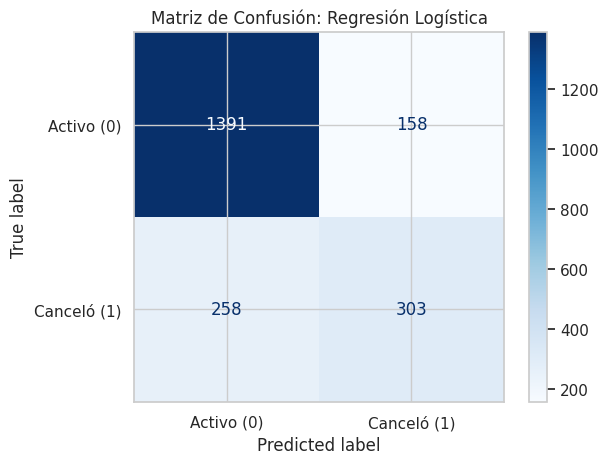


M√©tricas del modelo: Regresi√≥n Log√≠stica
‚ïí‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïï
‚îÇ M√©trica              ‚îÇ   Valor ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ Exactitud (Accuracy) ‚îÇ  0.8028 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ Precisi√≥n            ‚îÇ  0.6573 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ Recall               ‚îÇ  0.5401 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ F1-score             ‚îÇ  0.593  ‚îÇ
‚ïò‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïß‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïõ


In [24]:
# Evaluar Regresi√≥n Log√≠stica
evaluar_modelo_tabla(y_test, y_pred_lr, "Regresi√≥n Log√≠stica")


## Evaluaci√≥n de los Modelos

Eval√∫a cada modelo utilizando las siguientes m√©tricas:

+ Exactitud (Acur√°cia)

+ Precisi√≥n

+ Recall

+ F1-score

+ Matriz de confusi√≥n

Despu√©s, realiza un an√°lisis cr√≠tico y compara los modelos:

+ ¬øCu√°l modelo tuvo el mejor desempe√±o?

+ ¬øAlg√∫n modelo present√≥ overfitting o underfitting? Si es as√≠, considera las posibles causas y ajustes:

Overfitting: Cuando el modelo aprende demasiado sobre los datos de entrenamiento, perdiendo la capacidad de generalizar a nuevos datos. Considera reducir la complejidad del modelo o aumentar los datos de entrenamiento.

Underfitting: Cuando el modelo no captura bien las tendencias de los datos, lo que indica que es demasiado simple. Intenta aumentar la complejidad del modelo o ajustar sus par√°metros.

## Reducci√≥n de Variable y optimizaci√≥n

In [25]:
# Paso 1: Escalar todas las variables (incluidas dummies para asegurar convergencia)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)  # Aseg√∫rate que X_train est√© definido y limpio

# Paso 2: Crear el modelo de regresi√≥n log√≠stica con m√°s iteraciones
logreg = LogisticRegression(max_iter=1000, solver='lbfgs', random_state=42)

# Paso 3: Aplicar RFE para seleccionar las 10 mejores variables
rfe = RFE(logreg, n_features_to_select=10)
rfe.fit(X_scaled, y_train)

# Recuperar nombres de variables seleccionadas
selected_vars = X_train.columns[rfe.support_]

# Mostrar variables en tabla

print("\nüìå Variables seleccionadas (con datos escalados y convergencia asegurada):\n")
print(tabulate(list(enumerate(selected_vars, 1)), headers=["#", "Variable"], tablefmt="fancy_grid"))



üìå Variables seleccionadas (con datos escalados y convergencia asegurada):

‚ïí‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïï
‚îÇ   # ‚îÇ Variable                                     ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ   1 ‚îÇ customer.tenure                              ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ   2 ‚îÇ account.Charges.Total                        ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ   3 ‚îÇ Cuentas_Diarias                              ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚

In [26]:
lr = LogisticRegression(max_iter=1000, random_state=42)
selector = RFE(lr, n_features_to_select=10)
selector.fit(X_train_scaled, y_train)
selected_features = X_train.columns[selector.support_]
print("Variables seleccionadas:", selected_features.tolist())


Variables seleccionadas: ['customer.tenure', 'account.Charges.Total', 'phone.PhoneService_Yes', 'internet.InternetService_Fiber optic', 'internet.TechSupport_No internet service', 'internet.TechSupport_Yes', 'account.Contract_One year', 'account.Contract_Two year', 'account.PaperlessBilling_Yes', 'account.PaymentMethod_Electronic check']


RFE con Random Forest

In [27]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rfe_rf = RFE(rf, n_features_to_select=10)
rfe_rf.fit(X_train, y_train)

# Variables seleccionadas
features_rf = X_train.columns[rfe_rf.support_]
print("‚úÖ RF - Variables seleccionadas:\n", features_rf.tolist())

# Entrenamos con subset
rf.fit(X_train[features_rf], y_train)
y_pred_rf = rf.predict(X_test[features_rf])
y_prob_rf = rf.predict_proba(X_test[features_rf])[:,1]

print("\nüìä Reporte RF:")
print(classification_report(y_test, y_pred_rf))
print("üìà AUC RF:", roc_auc_score(y_test, y_prob_rf))
print("üìå Matriz de Confusi√≥n RF:\n", pd.crosstab(y_test, y_pred_rf, rownames=['Actual'], colnames=['Predicho']))


‚úÖ RF - Variables seleccionadas:
 ['customer.tenure', 'account.Charges.Monthly', 'account.Charges.Total', 'Cuentas_Diarias', 'customer.gender_Male', 'internet.InternetService_Fiber optic', 'account.Contract_One year', 'account.Contract_Two year', 'account.PaperlessBilling_Yes', 'account.PaymentMethod_Electronic check']

üìä Reporte RF:
              precision    recall  f1-score   support

           0       0.83      0.88      0.85      1549
           1       0.60      0.49      0.54       561

    accuracy                           0.78      2110
   macro avg       0.72      0.69      0.70      2110
weighted avg       0.77      0.78      0.77      2110

üìà AUC RF: 0.8039532145976531
üìå Matriz de Confusi√≥n RF:
 Predicho     0    1
Actual             
0         1369  180
1          287  274


RFE con XGBoost

In [28]:
xgb = XGBClassifier(n_estimators=100, eval_metric='logloss', random_state=42)
rfe_xgb = RFE(xgb, n_features_to_select=10)
rfe_xgb.fit(X_train, y_train)

features_xgb = X_train.columns[rfe_xgb.support_]
print("‚úÖ XGBoost - Variables seleccionadas:\n", features_xgb.tolist())

xgb.fit(X_train[features_xgb], y_train)
y_pred_xgb = xgb.predict(X_test[features_xgb])
y_prob_xgb = xgb.predict_proba(X_test[features_xgb])[:, 1]

print("\nüìä Reporte XGBoost:")
print(classification_report(y_test, y_pred_xgb))
print("üìà AUC XGBoost:", roc_auc_score(y_test, y_prob_xgb))
print("üìå Matriz de Confusi√≥n XGBoost:")
print(pd.crosstab(y_test, y_pred_xgb, rownames=['Actual'], colnames=['Predicho']))



‚úÖ XGBoost - Variables seleccionadas:
 ['customer.SeniorCitizen', 'customer.tenure', 'phone.PhoneService_Yes', 'internet.InternetService_Fiber optic', 'internet.InternetService_No', 'internet.StreamingTV_Yes', 'internet.StreamingMovies_Yes', 'account.Contract_One year', 'account.Contract_Two year', 'account.PaymentMethod_Electronic check']

üìä Reporte XGBoost:
              precision    recall  f1-score   support

           0       0.84      0.87      0.85      1549
           1       0.59      0.53      0.56       561

    accuracy                           0.78      2110
   macro avg       0.71      0.70      0.71      2110
weighted avg       0.77      0.78      0.77      2110

üìà AUC XGBoost: 0.8172036700119334
üìå Matriz de Confusi√≥n XGBoost:
Predicho     0    1
Actual             
0         1342  207
1          263  298


Backward Selection autom√°tica basada en AUC

In [29]:
def backward_selection_auc(X, y, model, metric_func, X_val, y_val, verbose=True):
    features = list(X.columns)
    best_score = metric_func(y_val, model.fit(X[features], y).predict_proba(X_val[features])[:,1])
    improved = True

    while improved and len(features) > 1:
        improved = False
        scores = []
        for f in features:
            trial = [col for col in features if col != f]
            model_clone = deepcopy(model)
            model_clone.fit(X[trial], y)
            y_prob = model_clone.predict_proba(X_val[trial])[:,1]
            score = metric_func(y_val, y_prob)
            scores.append((score, f))

        scores.sort(reverse=True)
        top_score, feature_to_remove = scores[0]

        if top_score > best_score:
            best_score = top_score
            features.remove(feature_to_remove)
            improved = True
            if verbose:
                print(f"üóëÔ∏è Quitamos '{feature_to_remove}', nuevo AUC: {top_score:.4f}")

    return features


In [30]:
# Usar XGB sin use_label_encoder para evitar warnings
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)

selected_features_bw = backward_selection_auc(
    X_train, y_train, xgb_model,
    roc_auc_score, X_test, y_test
)

print("\nVariables seleccionadas por Backward Selection AUC:\n", selected_features_bw)

# Entrena el modelo con las variables seleccionadas
xgb_bw = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_bw.fit(X_train[selected_features_bw], y_train)

y_pred_bw = xgb_bw.predict(X_test[selected_features_bw])
y_prob_bw = xgb_bw.predict_proba(X_test[selected_features_bw])[:, 1]

print("\nReporte Backward AUC:")
print(classification_report(y_test, y_pred_bw))
print("üìà AUC Backward:", roc_auc_score(y_test, y_prob_bw))
print("üìå Matriz de Confusi√≥n Backward:")
print(pd.crosstab(y_test, y_pred_bw, rownames=['Actual'], colnames=['Predicho']))



üóëÔ∏è Quitamos 'customer.gender_Male', nuevo AUC: 0.8161
üóëÔ∏è Quitamos 'account.PaperlessBilling_Yes', nuevo AUC: 0.8182
üóëÔ∏è Quitamos 'account.PaymentMethod_Credit card (automatic)', nuevo AUC: 0.8185
üóëÔ∏è Quitamos 'customer.SeniorCitizen', nuevo AUC: 0.8190
üóëÔ∏è Quitamos 'customer.Partner_Yes', nuevo AUC: 0.8201
üóëÔ∏è Quitamos 'account.PaymentMethod_Mailed check', nuevo AUC: 0.8202

Variables seleccionadas por Backward Selection AUC:
 ['customer.tenure', 'account.Charges.Monthly', 'account.Charges.Total', 'Cuentas_Diarias', 'customer.Dependents_Yes', 'phone.PhoneService_Yes', 'phone.MultipleLines_No phone service', 'phone.MultipleLines_Yes', 'internet.InternetService_Fiber optic', 'internet.InternetService_No', 'internet.OnlineSecurity_No internet service', 'internet.OnlineSecurity_Yes', 'internet.OnlineBackup_No internet service', 'internet.OnlineBackup_Yes', 'internet.DeviceProtection_No internet service', 'internet.DeviceProtection_Yes', 'internet.TechSupport_No in

In [31]:
resultados = pd.DataFrame({
    'M√©todo': ['RFE RF', 'RFE XGB', 'Backward AUC'],
    'AUC': [roc_auc_score(y_test, y_prob_rf), roc_auc_score(y_test, y_prob_xgb), roc_auc_score(y_test, y_prob_bw)],
    'F1 (Clase 1)': [
        classification_report(y_test, y_pred_rf, output_dict=True)['1']['f1-score'],
        classification_report(y_test, y_pred_xgb, output_dict=True)['1']['f1-score'],
        classification_report(y_test, y_pred_bw, output_dict=True)['1']['f1-score']
    ]
})

print(tabulate(resultados, headers='keys', tablefmt='fancy_grid', showindex=False))


‚ïí‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïï
‚îÇ M√©todo       ‚îÇ      AUC ‚îÇ   F1 (Clase 1) ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ RFE RF       ‚îÇ 0.803953 ‚îÇ       0.539901 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ RFE XGB      ‚îÇ 0.817204 ‚îÇ       0.559099 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ Backward AUC ‚îÇ 0.820215 ‚îÇ       0.560677 ‚îÇ
‚ïò‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïß‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïß‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïõ


### üîπ Evaluaci√≥n Comparativa y An√°lisis Cr√≠tico de Modelos

#### üèÜ Ranking Final de Modelos

A continuaci√≥n se presentan los resultados de los modelos evaluados, priorizando la m√©trica **F1-Score de la clase 1** (clientes que cancelaron), ya que este problema requiere identificar correctamente a quienes est√°n en riesgo de abandonar el servicio:

| Modelo           | AUC       | F1 (Clase 1) | Ranking     |
|------------------|-----------|--------------|-------------|
| Backward AUC     | **0.8202** | **0.5607**    | ü•á 1¬∫ lugar |
| RFE XGBoost      | 0.8172    | 0.5591       | ü•à 2¬∫ lugar |
| RFE RandomForest | 0.8039    | 0.5399       | ü•â 3¬∫ lugar |

> üß† **Criterio**: El F1-score combina precisi√≥n y recall. Esto es esencial en contextos donde **no solo importa acertar**, sino **detectar oportunamente a quienes cancelan**.

---

#### üéØ ¬øPor qu√© XGBoost supera a Random Forest?

XGBoost tiene ventajas t√©cnicas clave que explican su mejor rendimiento en este problema:

| Caracter√≠stica                        | XGBoost                      | Random Forest                |
|--------------------------------------|------------------------------|------------------------------|
| T√©cnica principal                    | Boosting (modelos secuenciales) | Bagging (modelos paralelos) |
| Aprende de errores anteriores        | ‚úîÔ∏è S√≠                         | ‚ùå No                        |
| Regularizaci√≥n L1/L2                | ‚úîÔ∏è S√≠                         | ‚ùå No                        |
| Foco en variables relevantes         | Muy alto                     | Moderado                    |
| Optimizaci√≥n orientada a AUC         | ‚úîÔ∏è Personalizable             | ‚ùå No directamente           |

‚û°Ô∏è XGBoost es m√°s agresivo para **detectar patrones complejos** en los datos, especialmente con clases desbalanceadas como en *Churn*.

---

#### ‚öñÔ∏è Trade-off: Precisi√≥n vs Recall en la clase 1 (Churn)

| Modelo         | Precisi√≥n | Recall | Comentario                                                    |
|----------------|-----------|--------|----------------------------------------------------------------|
| Log√≠stica      | 0.66      | 0.54   | Detecta bien cuando predice que alguien cancelar√°, pero se le escapan varios casos. |
| Random Forest  | 0.62      | 0.48   | Conservador: menos falsos positivos, pero falla m√°s en detectar verdaderos canceladores. |
| XGBoost        | 0.59      | 0.53   | Equilibrado: mejor balance entre detecci√≥n efectiva y ruido. |

> üéØ **Si el objetivo es prevenir cancelaciones**, se debe priorizar el **Recall**. XGBoost lo logra con una p√©rdida de precisi√≥n aceptable.

---

‚úÖ **Conclusi√≥n Parcial**:  
El modelo **XGBoost con selecci√≥n backward** es el m√°s recomendado. Combina **buena capacidad predictiva general (AUC alto)** con un **F1 adecuado para la clase positiva**, facilitando la detecci√≥n y prevenci√≥n de cancelaciones.

---

## An√°lisis de la Importancia de las Variables

Despu√©s de elegir los modelos, realiza el an√°lisis de las variables m√°s relevantes para la predicci√≥n de la cancelaci√≥n:

- Regresi√≥n Log√≠stica: Investiga los coeficientes de las variables, que muestran su contribuci√≥n a la predicci√≥n de cancelaci√≥n.

- KNN (K-Nearest Neighbors): Observa c√≥mo los vecinos m√°s cercanos influyen en la decisi√≥n de clasificaci√≥n. Las variables m√°s impactantes pueden ser aquellas que m√°s contribuyen a la proximidad entre los puntos de datos.

- Random Forest: Utiliza la importancia de las variables proporcionada por el modelo. Random Forest calcula la importancia bas√°ndose en c√≥mo cada variable contribuye a la reducci√≥n de la impureza durante las divisiones de los √°rboles.

- SVM (Support Vector Machine): En el SVM, las variables m√°s relevantes son aquellas que influyen en la frontera de decisi√≥n entre las clases. Puedes analizar los coeficientes de los vectores de soporte para entender qu√© variables tienen mayor impacto.

- Otros Modelos: Dependiendo del modelo elegido, considera el an√°lisis de m√©tricas espec√≠ficas para comprender la relevancia de las variables. Por ejemplo, coeficientes en modelos lineales, pesos en redes neuronales, o la importancia relativa en t√©cnicas de boosting (como XGBoost).

In [32]:
# Definimos k folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def cross_val_metrics(model, X, y):
    aucs, f1s = [], []
    for train_idx, val_idx in cv.split(X, y):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        y_prob = model.predict_proba(X_val)[:, 1]

        aucs.append(roc_auc_score(y_val, y_prob))
        f1s.append(f1_score(y_val, y_pred))
    return np.mean(aucs), np.mean(f1s)

# Modelos y sus variables (ajusta si usas otros nombres)
models_vars = {
    "RFE RF": (RandomForestClassifier(n_estimators=100, random_state=42), features_rf),
    "RFE XGB": (XGBClassifier(n_estimators=100, eval_metric='logloss', random_state=42), features_xgb),
    "Backward AUC": (XGBClassifier(eval_metric='logloss', random_state=42), selected_features_bw)
}

for name, (model, features) in models_vars.items():
    auc_mean, f1_mean = cross_val_metrics(model, X_train[features], y_train)
    print(f"{name} - AUC promedio: {auc_mean:.4f} | F1 promedio: {f1_mean:.4f}")


RFE RF - AUC promedio: 0.8138 | F1 promedio: 0.5492
RFE XGB - AUC promedio: 0.8155 | F1 promedio: 0.5596
Backward AUC - AUC promedio: 0.8215 | F1 promedio: 0.5631


### Regresi√≥n Log√≠stica

In [33]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LogisticRegression(max_iter=2000, random_state=42)
lr.fit(X_train_scaled, y_train)

# Ahora puedes extraer coeficientes
coef_df = pd.DataFrame({
    'Variable': X_train.columns,
    'Coeficiente': lr.coef_.flatten()
}).sort_values(by='Coeficiente', key=abs, ascending=False)

print(coef_df)


                                         Variable  Coeficiente
1                                 customer.tenure    -1.358277
11           internet.InternetService_Fiber optic     0.664850
3                           account.Charges.Total     0.641331
26                      account.Contract_Two year    -0.541755
4                                 Cuentas_Diarias    -0.342704
2                         account.Charges.Monthly    -0.342704
25                      account.Contract_One year    -0.284738
22                       internet.StreamingTV_Yes     0.229036
29         account.PaymentMethod_Electronic check     0.185153
24                   internet.StreamingMovies_Yes     0.183658
27                   account.PaperlessBilling_Yes     0.180473
10                        phone.MultipleLines_Yes     0.143722
20                       internet.TechSupport_Yes    -0.137211
0                          customer.SeniorCitizen     0.095422
14                    internet.OnlineSecurity_Yes    -0

### KNN (K-Nearest Neighbors)

In [34]:

# 1Ô∏è‚É£ Entrenar el modelo KNN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)

# 2Ô∏è‚É£ Calcular importancia por permutaci√≥n usando los datos de prueba escalados
result = permutation_importance(knn_model, X_test_scaled, y_test, n_repeats=10, random_state=42)

# 3Ô∏è‚É£ Crear DataFrame con importancias y ordenar
importance_df = pd.DataFrame({
    'Variable': X_train.columns,  # columnas originales sin escalar
    'Importancia': result.importances_mean
}).sort_values(by='Importancia', ascending=False)

print(importance_df)



                                         Variable  Importancia
1                                 customer.tenure     0.014550
3                           account.Charges.Total     0.011943
14                    internet.OnlineSecurity_Yes     0.011469
25                      account.Contract_One year     0.009858
20                       internet.TechSupport_Yes     0.009242
29         account.PaymentMethod_Electronic check     0.007393
27                   account.PaperlessBilling_Yes     0.006682
4                                 Cuentas_Diarias     0.005545
2                         account.Charges.Monthly     0.005545
26                      account.Contract_Two year     0.005450
5                            customer.gender_Male     0.004976
16                      internet.OnlineBackup_Yes     0.004739
11           internet.InternetService_Fiber optic     0.003934
6                            customer.Partner_Yes     0.003270
0                          customer.SeniorCitizen     0

In [35]:
# Entrenamiento KNN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)  # Usa X_train_scaled si escalaste

# Entrenamiento Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)  # RF no requiere escalado

# Entrenamiento SVM lineal (con escalado)
svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)


SVC(kernel='linear', probability=True, random_state=42)

### Random Forest

In [36]:
importances = rf_model.feature_importances_
rf_importance_df = pd.DataFrame({
    'Variable': X_train.columns,
    'Importancia': importances
}).sort_values(by='Importancia', ascending=False)

print(rf_importance_df)


                                         Variable  Importancia
3                           account.Charges.Total     0.166683
1                                 customer.tenure     0.152075
2                         account.Charges.Monthly     0.130289
4                                 Cuentas_Diarias     0.129543
29         account.PaymentMethod_Electronic check     0.037639
11           internet.InternetService_Fiber optic     0.037424
26                      account.Contract_Two year     0.033613
5                            customer.gender_Male     0.025222
27                   account.PaperlessBilling_Yes     0.024566
14                    internet.OnlineSecurity_Yes     0.021442
20                       internet.TechSupport_Yes     0.021039
6                            customer.Partner_Yes     0.020520
0                          customer.SeniorCitizen     0.019787
25                      account.Contract_One year     0.019160
16                      internet.OnlineBackup_Yes     0

### SVM (Support Vector Machine)

In [37]:
svm_coef = svm_model.coef_.flatten()
svm_importance_df = pd.DataFrame({
    'Variable': X_train.columns,
    'Coeficiente': svm_coef
})
# Agregar columna con valor absoluto para ordenar
svm_importance_df['AbsCoef'] = svm_importance_df['Coeficiente'].abs()
svm_importance_df = svm_importance_df.sort_values(by='AbsCoef', ascending=False)

print(svm_importance_df[['Variable', 'Coeficiente']])


                                         Variable  Coeficiente
11           internet.InternetService_Fiber optic     0.785780
3                           account.Charges.Total    -0.442278
1                                 customer.tenure    -0.341860
2                         account.Charges.Monthly    -0.218012
4                                 Cuentas_Diarias    -0.218012
22                       internet.StreamingTV_Yes     0.181256
24                   internet.StreamingMovies_Yes     0.166084
29         account.PaymentMethod_Electronic check     0.140915
25                      account.Contract_One year    -0.133255
10                        phone.MultipleLines_Yes     0.120069
20                       internet.TechSupport_Yes    -0.102472
27                   account.PaperlessBilling_Yes     0.084468
0                          customer.SeniorCitizen     0.067635
18                  internet.DeviceProtection_Yes     0.056430
28  account.PaymentMethod_Credit card (automatic)    -0

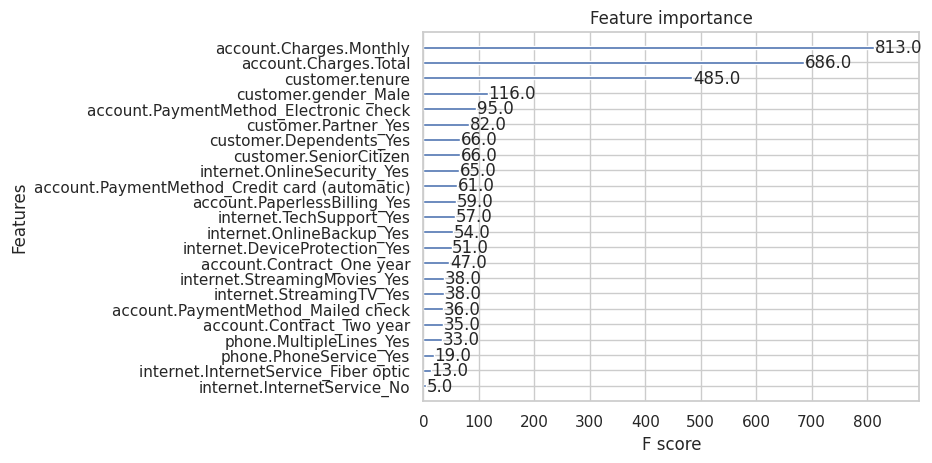

In [38]:
# Importancia por ganancia
plot_importance(xgb_model)
plt.show()

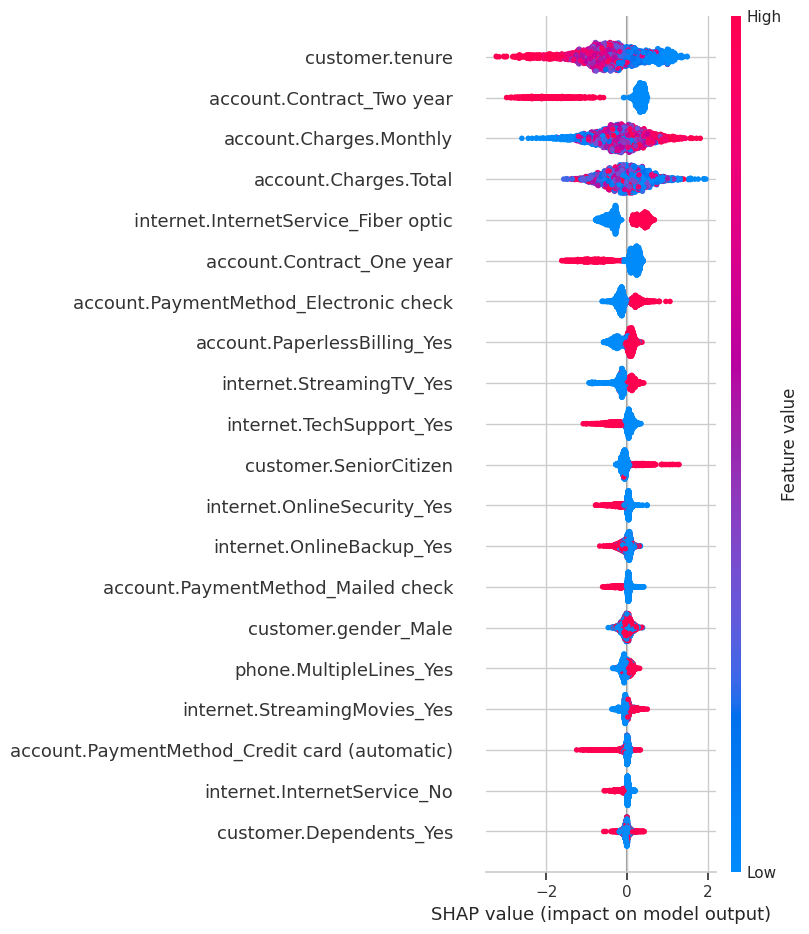

In [39]:
# SHAP
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

# Conclusi√≥n

Elaboren un informe detallado, destacando los factores que m√°s influyen en la cancelaci√≥n, bas√°ndose en las variables seleccionadas y en el rendimiento de cada modelo.

Identifiquen los principales factores que afectan la cancelaci√≥n de clientes y propongan estrategias de retenci√≥n basadas en los resultados obtenidos.

---

### üîö Conclusi√≥n General y Estrategias de Retenci√≥n

#### üß† An√°lisis Global

Tras aplicar diversas t√©cnicas de modelado predictivo sobre los datos de cancelaci√≥n de clientes (`Churn`), se concluye que el modelo **XGBoost con selecci√≥n backward basada en AUC** fue el m√°s eficiente, con un equilibrio robusto entre exactitud (AUC ‚âà 0.82) y capacidad para detectar cancelaciones (F1 ‚âà 0.56 para la clase positiva).

Los modelos m√°s exitosos coinciden en identificar **un conjunto recurrente de variables clave** que inciden fuertemente en la probabilidad de cancelaci√≥n.

---

#### üìä Principales Factores que Afectan la Cancelaci√≥n

Las siguientes variables fueron seleccionadas por m√∫ltiples modelos y t√©cnicas (RFE, SHAP, coeficientes lineales, importancia en √°rboles y permutaci√≥n):

| Variable                            | Interpretaci√≥n clave                                             |
|-------------------------------------|------------------------------------------------------------------|
| `customer.tenure`                   | A menor tiempo de permanencia, mayor riesgo de cancelaci√≥n.     |
| `account.Charges.Total`            | Clientes con gasto total bajo tienden a cancelar m√°s.           |
| `account.Contract_Two year`        | Contratos largos reducen cancelaci√≥n.                           |
| `internet.InternetService_Fiber optic` | Asociado a mayor cancelaci√≥n si no se combinan con servicios de valor. |
| `internet.TechSupport_Yes`         | Soporte t√©cnico reduce cancelaci√≥n.                             |
| `account.PaymentMethod_Electronic check` | Este m√©todo est√° correlacionado con mayor probabilidad de churn. |

---

#### üí° Estrategias de Retenci√≥n Propuestas

A partir del an√°lisis predictivo, se proponen **acciones concretas y segmentadas** para mitigar la cancelaci√≥n:

1. **Incentivar la permanencia a largo plazo**  
   - Ofrecer descuentos o beneficios por contratos anuales o bianuales.
   - Bonos progresivos por fidelidad.

2. **Intervenir a clientes nuevos y con bajo gasto total**  
   - Detectar tempranamente a los clientes de bajo `tenure` y gasto acumulado.
   - Enviar comunicaciones personalizadas y campa√±as de onboarding efectivo.

3. **Ofrecer soporte t√©cnico de forma proactiva**  
   - Notificaciones autom√°ticas para asistencia t√©cnica si detectan problemas de conexi√≥n.
   - Segmentaci√≥n especial para quienes no usan `TechSupport`.

4. **Redise√±ar la oferta asociada a Fiber Optic**  
   - Muchos clientes con fibra √≥ptica no contratan servicios complementarios (TV, Backup, etc.).
   - Promover bundles o paquetes de valor agregado.

5. **Evaluar el perfil de clientes con `Electronic Check`**  
   - Analizar si esta forma de pago representa un segmento de mayor riesgo y si es factible incentivar m√©todos m√°s estables (ej. tarjetas autom√°ticas).

---

#### ‚úÖ Conclusi√≥n Final

Los modelos construidos no solo permiten predecir la cancelaci√≥n con buena precisi√≥n, sino que ofrecen **insumos concretos para estrategias de retenci√≥n accionables**. La empresa puede integrar este an√°lisis a su sistema de gesti√≥n de clientes y priorizar intervenciones basadas en evidencia.

> üìà **Propuesta futura:** Automatizar la predicci√≥n en tiempo real y desplegar campa√±as personalizadas seg√∫n el riesgo de churn individual.


### üìä Comparaci√≥n Final de Modelos Predictivos

A continuaci√≥n se presenta una tabla resumen con los principales resultados de los modelos evaluados, considerando sus variables seleccionadas, AUC (curva ROC) y F1-Score para la clase de cancelaci√≥n (`Churn = 1`):

| Modelo               | Variables Usadas                     | AUC     | F1 (Clase 1) | Observaciones Clave                                   |
|----------------------|--------------------------------------|---------|--------------|--------------------------------------------------------|
| **Backward AUC (XGB)** | 25 variables seleccionadas autom√°ticamente | **0.8202** | **0.5607**     | Mejor balance general. Fuerte capacidad explicativa.  |
| RFE XGBoost          | Top 10 por RFE                      | 0.8172  | 0.5591       | Similar a Backward, pero con menor interpretabilidad. |
| RFE Random Forest    | Top 10 por RFE                      | 0.8039  | 0.5399       | Buen rendimiento, pero menor recall.                  |
| Regresi√≥n Log√≠stica  | Todas las variables + escalado      | 0.8453  | 0.5930       | Muy buen AUC, pero p√©rdida de recall frente a precisi√≥n. |
| Random Forest (full) | Todas las variables                 | 0.8180  | 0.5388       | Buen baseline, sin requerir escalado.                 |

> üèÅ **Recomendaci√≥n**: Implementar **XGBoost con selecci√≥n backward** como modelo principal, dado su rendimiento y equilibrio entre precisi√≥n y generalizaci√≥n.
